# Projet 4 - Partie exploratoire

Vous êtes Data Scientist au sein d'une société financière, nommée "Prêt à dépenser",  qui propose des crédits à la consommation pour des personnes ayant peu ou pas d'historique de prêt.

 

Pour accorder un crédit à la consommation, l’entreprise souhaite mettre en œuvre un outil de “scoring crédit” qui calcule la probabilité qu’un client le rembourse ou non, puis classifie la demande : crédit accordé ou refusé. Elle souhaite donc développer un algorithme de classification pour aider à décider si un prêt peut être accordé à un client.

Les chargés de relation client seront les utilisateurs de l’outil de scoring. Puisqu’ils s’adressent aux clients, ils ont besoin que votre modèle soit facilement interprétable. Les chargés de relation souhaitent, en plus, disposer d’une mesure de l’importance des variables qui ont poussé le modèle à donner cette probabilité à un client.

Pour réaliser ce modèle, Michaël, votre manager, vous a fourni le jeu de données suivant qui contient :

un historique de prêts ;
un historique d’informations financières ;
des informations sur le comportement des emprunteurs (si l’emprunteur a fait défaut ou pas). 

In [1]:
%pip install numpy
%pip install pandas
%pip install matplotlib
%pip install seaborn
%pip install -U scikit-learn


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 9.3 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1
ERROR: pip's dependency resolve

In [2]:
# numpy and pandas for data manipulation
import numpy as np
import pandas as pd 

# sklearn preprocessing for dealing with categorical variables
from sklearn.preprocessing import LabelEncoder

# File system manangement
import os

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns

#Imputations
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.compose import ColumnTransformer


In [3]:
# Training data
df_application = pd.read_csv('../../data/raw/application_train.csv', nrows=100000)
df_bureau_balance = pd.read_csv('../../data/raw/bureau_balance.csv')
df_bureau = pd.read_csv('../../data/raw/bureau.csv')
df_application_test = pd.read_csv('../../data/raw/application_test.csv')
"""
df_application_test = pd.read_csv('./data/application_test.csv')
df_credit_card_balance = pd.read_csv('./data/credit_card_balance.csv')
df_HomeCredit_columns_description = pd.read_csv('./data/HomeCredit_columns_description.csv')
df_installments_payments = pd.read_csv('./data/installments_payments.csv')
df_POS_CASH_balance = pd.read_csv('./data/POS_CASH_balance.csv')
df_POS_CASH_balance = pd.read_csv('./data/POS_CASH_balance.csv')
df_sample_submission = pd.read_csv('./data/sample_submission.csv')
"""
print('Training data shape: ', df_application.shape)
df_application.head()

Training data shape:  (100000, 122)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
df_application['TARGET'].value_counts()


TARGET
0    91907
1     8093
Name: count, dtype: int64

La target correspond à ce que l'on veut prédire. Si c'est 1, la personne n' a pas remboursé, si c'est 0, elle a remboursé son paiement.


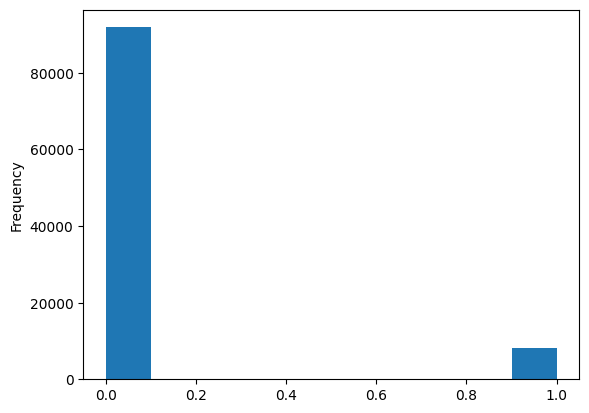

In [5]:
df_application['TARGET'].astype(int).plot.hist();


In [6]:
# Function to calculate missing values by column# Funct 
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [7]:
missing_values_table(df_application)

Your selected dataframe has 122 columns.
There are 67 columns that have missing values.


,Missing Values,% of Total Values
COMMONAREA_MEDI,69732,69.7
COMMONAREA_AVG,69732,69.7
COMMONAREA_MODE,69732,69.7
NONLIVINGAPARTMENTS_MEDI,69275,69.3
NONLIVINGAPARTMENTS_MODE,69275,69.3
...,...,...
EXT_SOURCE_2,215,0.2
AMT_GOODS_PRICE,81,0.1
AMT_ANNUITY,7,0.0
DAYS_LAST_PHONE_CHANGE,1,0.0


To do : continer l'analyse exploratoire  
objectif : avoir un df qui continent les valeurs les plus importantes

In [8]:
# Column types
df_application.dtypes.value_counts()

float64    65
int64      41
object     16
Name: count, dtype: int64

In [9]:
#Number of unique classes in each object column
df_application.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

In [10]:
# Create a label encoder object
le = LabelEncoder()
le_count = 0

# Iterate through the columns
for col in df_application:
    if df_application[col].dtype == 'object':
        # If 2 or fewer unique categories
        if len(list(df_application[col].unique())) <= 2:
            # Train on the training data
            le.fit(df_application[col])
            # Transform both training and testing data
            df_application[col] = le.transform(df_application[col])
            df_application_test[col] = le.transform(df_application_test[col])
            
            # Keep track of how many columns were label encoded
            le_count += 1
            
print('%d columns were label encoded.' % le_count)

3 columns were label encoded.


In [11]:
# one-hot encoding of categorical variables
# REGARDER : on transforme les variables catégorielles en variables numériques
df_application = pd.get_dummies(df_application)

df_application_test = pd.get_dummies(df_application_test)

print('Training Features shape: ', df_application.shape)
print('Testing Features shape: ', df_application_test.shape)

Training Features shape:  (100000, 243)
Testing Features shape:  (48744, 239)


In [12]:
train_labels = df_application['TARGET']

# Align the training and testing data, keep only columns present in both dataframes
df_application, df_application_test = df_application.align(df_application_test, join = 'inner', axis = 1)

# Add the target back in
df_application['TARGET'] = train_labels

print('Training Features shape: ', df_application.shape)
print('Testing Features shape: ', df_application_test.shape)

Training Features shape:  (100000, 240)
Testing Features shape:  (48744, 239)


In [13]:
(df_application['DAYS_BIRTH'] / -365).describe()

count    100000.000000
mean         43.908091
std          11.967967
min          21.030137
25%          33.947260
50%          43.128767
75%          53.884932
max          69.043836
Name: DAYS_BIRTH, dtype: float64

In [14]:
df_application['DAYS_EMPLOYED'].describe()

count    100000.000000
mean      63292.222060
std      140839.697296
min      -17531.000000
25%       -2758.000000
50%       -1219.000000
75%        -291.000000
max      365243.000000
Name: DAYS_EMPLOYED, dtype: float64

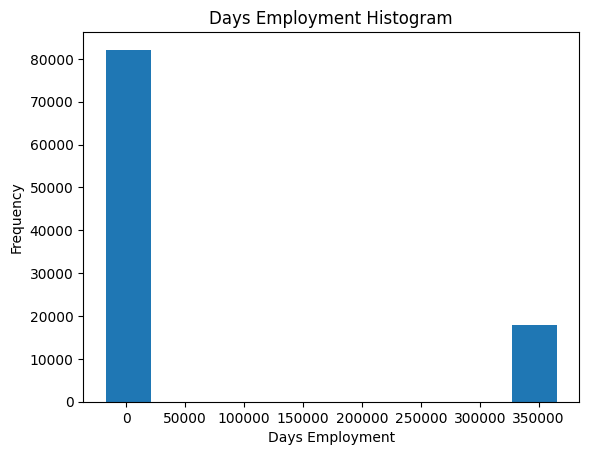

In [15]:
df_application['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram');
plt.xlabel('Days Employment');

In [16]:
anom = df_application[df_application['DAYS_EMPLOYED'] == 365243]
non_anom = df_application[df_application['DAYS_EMPLOYED'] != 365243]
print('The non-anomalies default on %0.2f%% of loans' % (100 * non_anom['TARGET'].mean()))
print('The anomalies default on %0.2f%% of loans' % (100 * anom['TARGET'].mean()))
print('There are %d anomalous days of employment' % len(anom))

The non-anomalies default on 8.66% of loans
The anomalies default on 5.50% of loans
There are 17865 anomalous days of employment


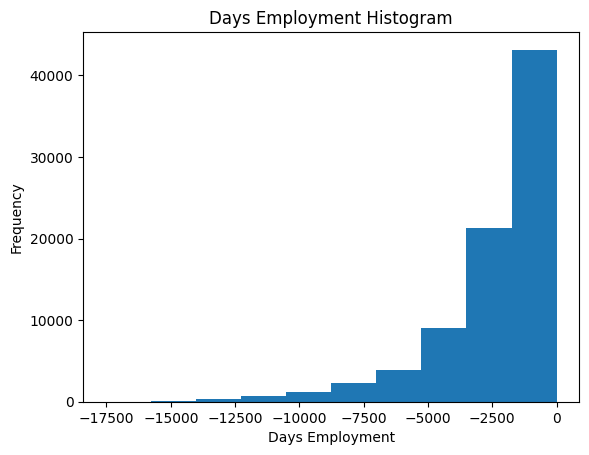

In [17]:
# Create an anomalous flag column
df_application['DAYS_EMPLOYED_ANOM'] = df_application["DAYS_EMPLOYED"] == 365243

# Replace the anomalous values with nan
df_application['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)

df_application['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram');
plt.xlabel('Days Employment');

In [18]:
df_application_test['DAYS_EMPLOYED_ANOM'] = df_application_test["DAYS_EMPLOYED"] == 365243
df_application_test["DAYS_EMPLOYED"].replace({365243: np.nan}, inplace = True)

print('There are %d anomalies in the test data out of %d entries' % (df_application_test["DAYS_EMPLOYED_ANOM"].sum(), len(df_application_test)))

There are 9274 anomalies in the test data out of 48744 entries


In [19]:
# Find correlations with the target and sort
correlations = df_application.corr()['TARGET'].sort_values()

# Display correlations
print('Most Positive Correlations:\n', correlations.tail(15))
print('\nMost Negative Correlations:\n', correlations.head(15))

Most Positive Correlations:
 OWN_CAR_AGE                                          0.043350
FLAG_DOCUMENT_3                                      0.043778
OCCUPATION_TYPE_Laborers                             0.044127
FLAG_EMP_PHONE                                       0.044348
REG_CITY_NOT_WORK_CITY                               0.048274
NAME_EDUCATION_TYPE_Secondary / secondary special    0.051143
DAYS_ID_PUBLISH                                      0.051795
DAYS_LAST_PHONE_CHANGE                               0.053020
CODE_GENDER_M                                        0.055279
NAME_INCOME_TYPE_Working                             0.057063
REGION_RATING_CLIENT                                 0.061597
REGION_RATING_CLIENT_W_CITY                          0.062816
DAYS_EMPLOYED                                        0.072739
DAYS_BIRTH                                           0.076838
TARGET                                               1.000000
Name: TARGET, dtype: float64

Most Negati

In [20]:
# Find the correlation of the positive days since birth and target
df_application['DAYS_BIRTH'] = abs(df_application['DAYS_BIRTH'])
df_application['DAYS_BIRTH'].corr(df_application['TARGET'])

np.float64(-0.0768378320303758)

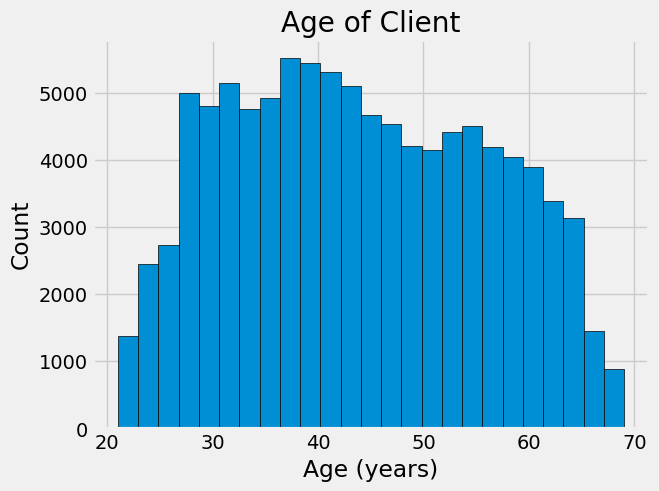

In [21]:
# Set the style of plots
plt.style.use('fivethirtyeight')

# Plot the distribution of ages in years
plt.hist(df_application['DAYS_BIRTH'] / 365, edgecolor = 'k', bins = 25)
plt.title('Age of Client'); plt.xlabel('Age (years)'); plt.ylabel('Count');

#Commenter le graphe

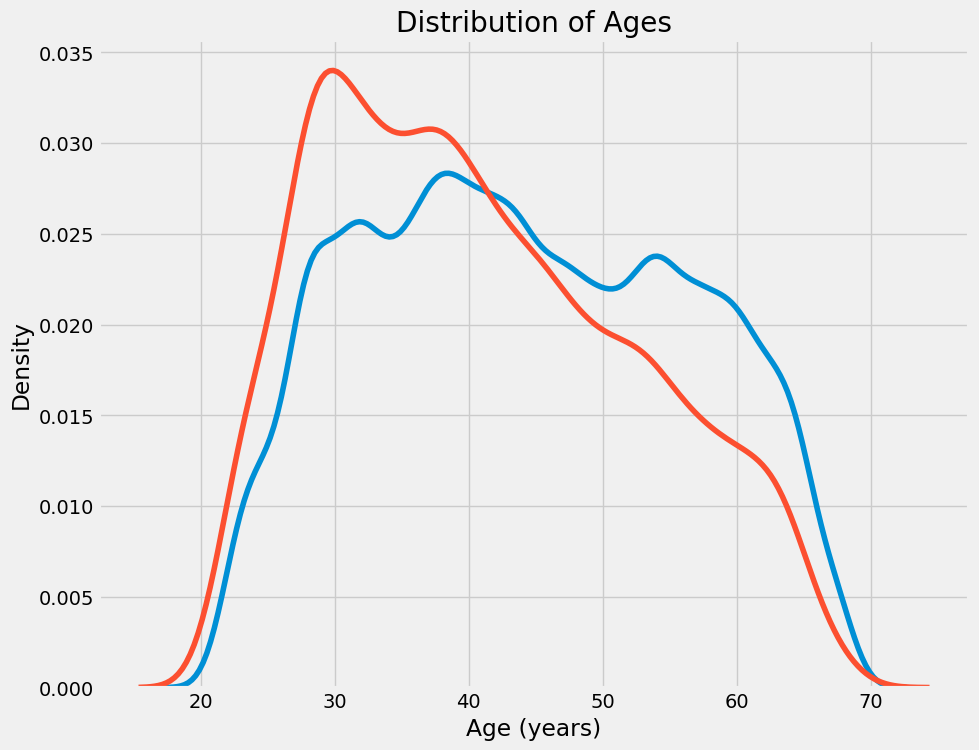

In [22]:
plt.figure(figsize = (10, 8))

# KDE plot of loans that were repaid on time
sns.kdeplot(df_application.loc[df_application['TARGET'] == 0, 'DAYS_BIRTH'] / 365, label = 'target == 0')

# KDE plot of loans which were not repaid on time
sns.kdeplot(df_application.loc[df_application['TARGET'] == 1, 'DAYS_BIRTH'] / 365, label = 'target == 1')

# Labeling of plot
plt.xlabel('Age (years)'); plt.ylabel('Density'); plt.title('Distribution of Ages');

In [23]:
# Age information into a separate dataframe
age_data = df_application[['TARGET', 'DAYS_BIRTH']]
age_data['YEARS_BIRTH'] = age_data['DAYS_BIRTH'] / 365

# Bin the age data
age_data['YEARS_BINNED'] = pd.cut(age_data['YEARS_BIRTH'], bins = np.linspace(20, 70, num = 11))
age_data.head(10)

,TARGET,DAYS_BIRTH,YEARS_BIRTH,YEARS_BINNED
0,1,9461,25.920548,"(25.0, 30.0]"
1,0,16765,45.931507,"(45.0, 50.0]"
2,0,19046,52.180822,"(50.0, 55.0]"
3,0,19005,52.068493,"(50.0, 55.0]"
4,0,19932,54.608219,"(50.0, 55.0]"
5,0,16941,46.413699,"(45.0, 50.0]"
6,0,13778,37.747945,"(35.0, 40.0]"
7,0,18850,51.643836,"(50.0, 55.0]"
8,0,20099,55.065753,"(55.0, 60.0]"
9,0,14469,39.641096,"(35.0, 40.0]"


In [24]:
# Group by the bin and calculate averages
age_groups  = age_data.groupby('YEARS_BINNED').mean()
age_groups

,TARGET,DAYS_BIRTH,YEARS_BIRTH
YEARS_BINNED,,,
"(20.0, 25.0]",0.119900,8524.113184,23.353735
"(25.0, 30.0]",0.114366,10154.587127,27.820787
"(30.0, 35.0]",0.099618,11851.435732,32.469687
"(35.0, 40.0]",0.089474,13704.670159,37.547042
"(40.0, 45.0]",0.078916,15499.119904,42.463342
"(45.0, 50.0]",0.075376,17327.096275,47.471497
"(50.0, 55.0]",0.067856,19192.066626,52.581004
"(55.0, 60.0]",0.054584,20986.344802,57.496835
"(60.0, 65.0]",0.054690,22781.301020,62.414523


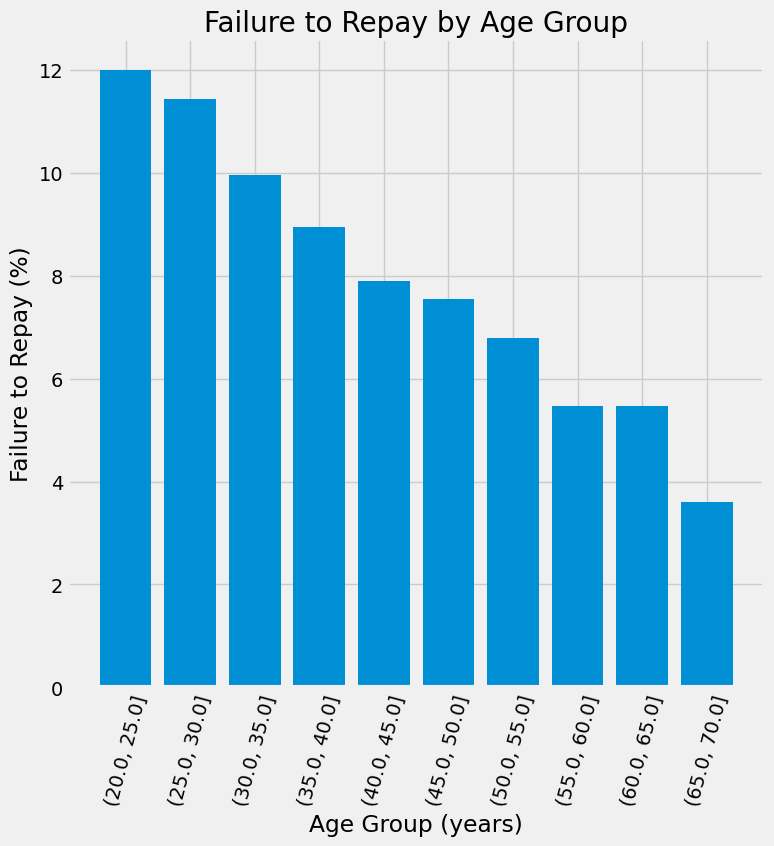

In [25]:
plt.figure(figsize = (8, 8))

# Graph the age bins and the average of the target as a bar plot
plt.bar(age_groups.index.astype(str), 100 * age_groups['TARGET'])

# Plot labeling
plt.xticks(rotation = 75); plt.xlabel('Age Group (years)'); plt.ylabel('Failure to Repay (%)')
plt.title('Failure to Repay by Age Group');

In [26]:
df_application.head(5)

,SK_ID_CURR,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,...,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,TARGET,DAYS_EMPLOYED_ANOM
0,100002,0,0,1,0,202500.0,406597.5,24700.5,351000.0,0.018801,...,False,False,False,False,True,False,True,False,1,False
1,100003,0,0,0,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,...,False,False,False,False,False,False,True,False,0,False
2,100004,1,1,1,0,67500.0,135000.0,6750.0,135000.0,0.010032,...,False,False,False,False,False,False,False,False,0,False
3,100006,0,0,1,0,135000.0,312682.5,29686.5,297000.0,0.008019,...,False,False,False,False,False,False,False,False,0,False
4,100007,0,0,1,0,121500.0,513000.0,21865.5,513000.0,0.028663,...,False,False,False,False,False,False,False,False,0,False


In [27]:
# Extract the EXT_SOURCE variables and show correlations
ext_data = df_application[['TARGET', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]
ext_data_corrs = ext_data.corr()
ext_data_corrs

,TARGET,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_BIRTH
TARGET,1.000000,-0.153105,-0.161657,-0.178734,-0.076838
EXT_SOURCE_1,-0.153105,1.000000,0.215801,0.185798,0.604018
EXT_SOURCE_2,-0.161657,0.215801,1.000000,0.108779,0.092393
EXT_SOURCE_3,-0.178734,0.185798,0.108779,1.000000,0.209854
DAYS_BIRTH,-0.076838,0.604018,0.092393,0.209854,1.000000


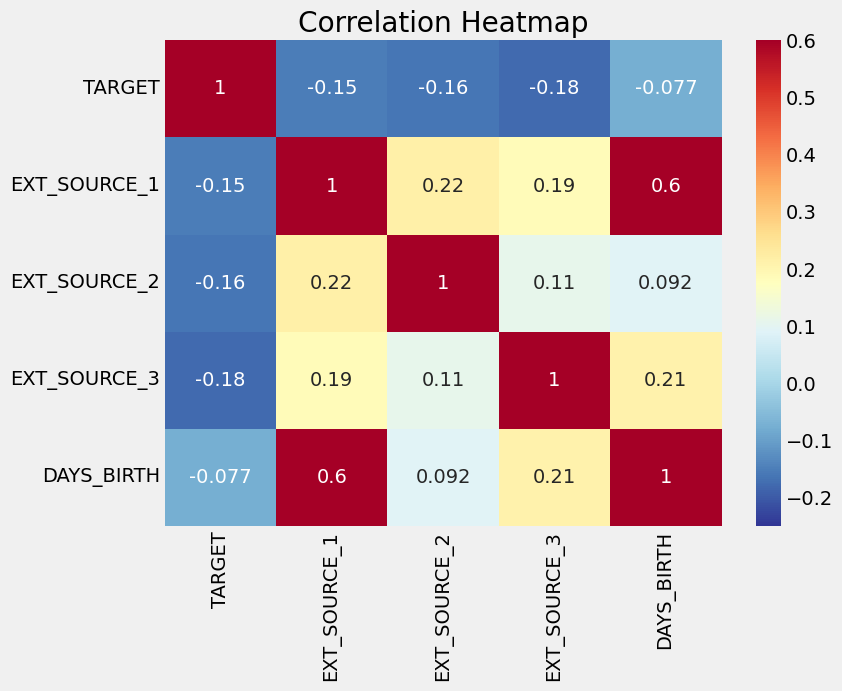

In [28]:
plt.figure(figsize = (8, 6))

# Heatmap of correlations
sns.heatmap(ext_data_corrs, cmap = plt.cm.RdYlBu_r, vmin = -0.25, annot = True, vmax = 0.6)
plt.title('Correlation Heatmap');

Commenter le graphique

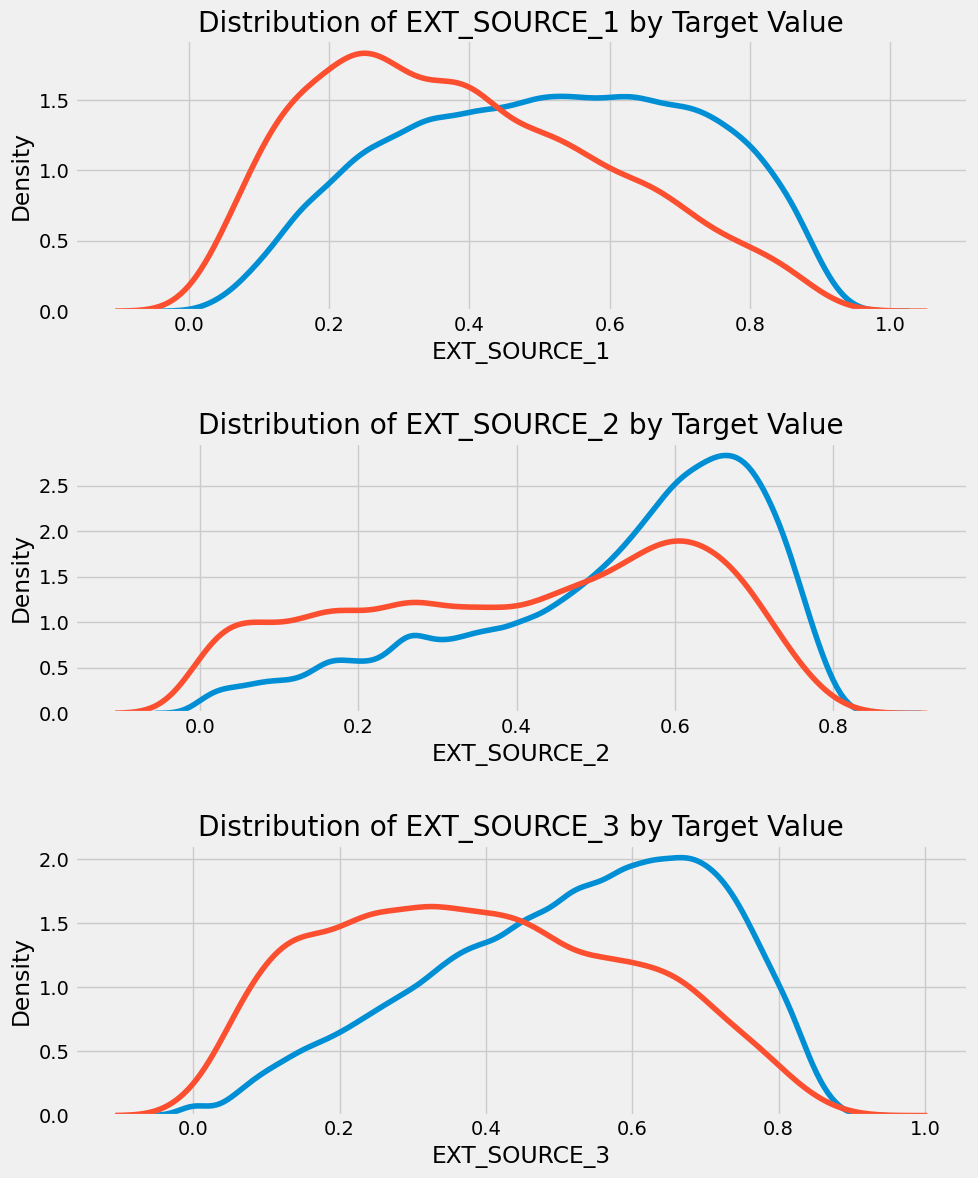

In [29]:
plt.figure(figsize = (10, 12))

# iterate through the sources
for i, source in enumerate(['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']):
    
    # create a new subplot for each source
    plt.subplot(3, 1, i + 1)
    # plot repaid loans
    sns.kdeplot(df_application.loc[df_application['TARGET'] == 0, source], label = 'target == 0')
    # plot loans that were not repaid
    sns.kdeplot(df_application.loc[df_application['TARGET'] == 1, source], label = 'target == 1')
    
    # Label the plots
    plt.title('Distribution of %s by Target Value' % source)
    plt.xlabel('%s' % source); plt.ylabel('Density');
    
plt.tight_layout(h_pad = 2.5)

KeyboardInterrupt: 

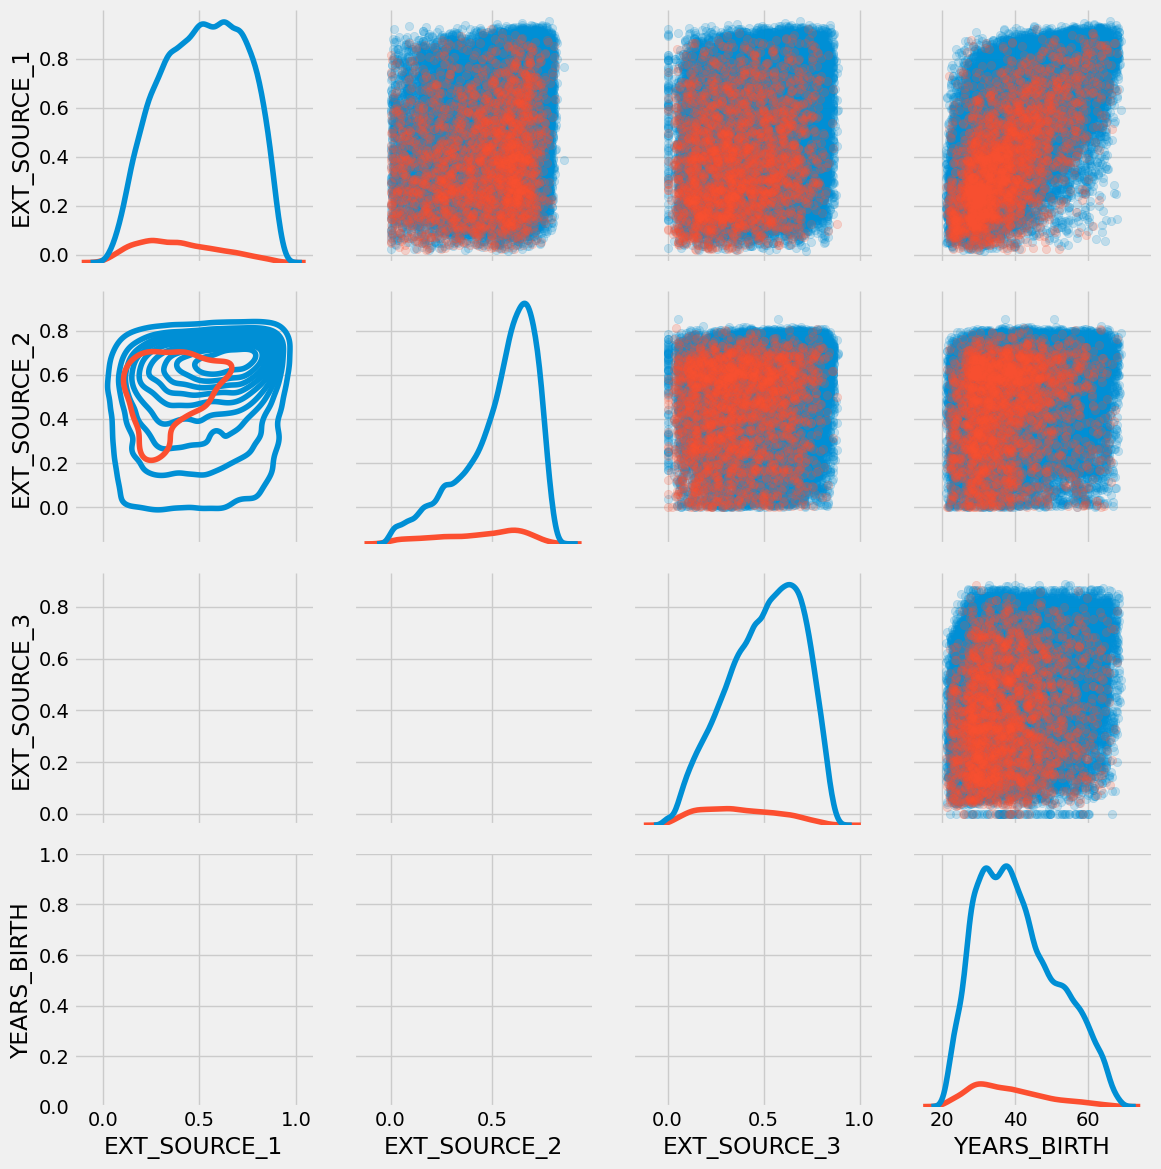

In [31]:
# Copy the data for plotting
plot_data = ext_data.drop(columns = ['DAYS_BIRTH']).copy()

# Add in the age of the client in years
plot_data['YEARS_BIRTH'] = age_data['YEARS_BIRTH']

# Drop na values and limit to first 100000 rows
plot_data = plot_data.dropna().loc[:100000, :]

# Function to calculate correlation coefficient between two columns
def corr_func(x, y, **kwargs):
    r = np.corrcoef(x, y)[0][1]
    ax = plt.gca()
    ax.annotate("r = {:.2f}".format(r),
                xy=(.2, .8), xycoords=ax.transAxes,
                size = 20)

# Create the pairgrid object
grid = sns.PairGrid(data=plot_data, height=3, diag_sharey=False,
                    hue='TARGET', 
                    vars=[x for x in list(plot_data.columns) if x != 'TARGET'])


# Upper is a scatter plot
grid.map_upper(plt.scatter, alpha = 0.2)

# Diagonal is a histogram
grid.map_diag(sns.kdeplot)

# Bottom is density plot
grid.map_lower(sns.kdeplot, cmap = plt.cm.OrRd_r);

plt.suptitle('Ext Source and Age Features Pairs Plot', size = 32, y = 1.05);

## Partie 2 - feature engineering

On va modifier , faire une création et une sélection de features afin de la valeur et de faciliter le machine learning plus tard.

In [32]:
df_application.head(1)

,SK_ID_CURR,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,...,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,TARGET,DAYS_EMPLOYED_ANOM
0,100002,0,0,1,0,202500.0,406597.5,24700.5,351000.0,0.018801,...,False,False,False,False,True,False,True,False,1,False


In [33]:
pd.set_option('display.max_columns', None)
df_application.columns.to_list()


['SK_ID_CURR',
 'NAME_CONTRACT_TYPE',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'CNT_CHILDREN',
 'AMT_INCOME_TOTAL',
 'AMT_CREDIT',
 'AMT_ANNUITY',
 'AMT_GOODS_PRICE',
 'REGION_POPULATION_RELATIVE',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_REGISTRATION',
 'DAYS_ID_PUBLISH',
 'OWN_CAR_AGE',
 'FLAG_MOBIL',
 'FLAG_EMP_PHONE',
 'FLAG_WORK_PHONE',
 'FLAG_CONT_MOBILE',
 'FLAG_PHONE',
 'FLAG_EMAIL',
 'CNT_FAM_MEMBERS',
 'REGION_RATING_CLIENT',
 'REGION_RATING_CLIENT_W_CITY',
 'HOUR_APPR_PROCESS_START',
 'REG_REGION_NOT_LIVE_REGION',
 'REG_REGION_NOT_WORK_REGION',
 'LIVE_REGION_NOT_WORK_REGION',
 'REG_CITY_NOT_LIVE_CITY',
 'REG_CITY_NOT_WORK_CITY',
 'LIVE_CITY_NOT_WORK_CITY',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'APARTMENTS_AVG',
 'BASEMENTAREA_AVG',
 'YEARS_BEGINEXPLUATATION_AVG',
 'YEARS_BUILD_AVG',
 'COMMONAREA_AVG',
 'ELEVATORS_AVG',
 'ENTRANCES_AVG',
 'FLOORSMAX_AVG',
 'FLOORSMIN_AVG',
 'LANDAREA_AVG',
 'LIVINGAPARTMENTS_AVG',
 'LIVINGAREA_AVG',
 'NONLIVINGAPARTMENTS_AVG',
 'NON

Regader la liste des features à prendre

A faire : ceci est juste un exemple, on sélectionnera beaucoup plus de features. 
On séléctionne les features. On sait que external_source_1 2 et 3 sont pertinanentes. On selectionne des variables pertinnentespour l'analyse exploratoire et en fonction de nos connaissances métier.

In [34]:
list_features_selected = ['SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE', 'EXT_SOURCE_1', 'EXT_SOURCE_2',
                           'EXT_SOURCE_3', 'CODE_GENDER_F', 'CODE_GENDER_M', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'DAYS_BIRTH',
                           'DAYS_EMPLOYED','OWN_CAR_AGE', 'NAME_INCOME_TYPE_Businessman',
 'NAME_INCOME_TYPE_Commercial associate',
 'NAME_INCOME_TYPE_Pensioner',
 'NAME_INCOME_TYPE_State servant',
 'NAME_INCOME_TYPE_Student',
 'NAME_INCOME_TYPE_Unemployed',
 'NAME_INCOME_TYPE_Working',
  'NAME_EDUCATION_TYPE_Academic degree',
 'NAME_EDUCATION_TYPE_Higher education',
 'NAME_EDUCATION_TYPE_Incomplete higher',
 'NAME_EDUCATION_TYPE_Lower secondary',
 'NAME_EDUCATION_TYPE_Secondary / secondary special']


In [35]:
#df_application_selected = df_application[['SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE', 'EXT_SOURCE_1', 'EXT_SOURCE_2'  , 'EXT_SOURCE_3', 'CODE_GENDER_F', 'CODE_GENDER_M', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT']]
df_application_selected = df_application[list_features_selected]
df_application_selected.sample(3)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,CODE_GENDER_F,CODE_GENDER_M,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,DAYS_BIRTH,DAYS_EMPLOYED,OWN_CAR_AGE,NAME_INCOME_TYPE_Businessman,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Academic degree,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special
82728,195947,0,0,NaN,0.429300,0.481249,False,True,0,135000.0,508495.5,18040,-643.0,24.0,False,False,False,False,False,False,True,False,False,False,False,True
81,100096,1,0,NaN,0.023952,0.720944,True,False,0,81000.0,252000.0,24794,NaN,NaN,False,False,True,False,False,False,False,False,False,False,False,True
66163,176739,0,0,0.130311,0.244460,NaN,True,False,3,135000.0,594121.5,9999,-1049.0,NaN,False,False,False,False,False,False,True,False,False,False,False,True


On va effectuer du feature engineering. On va donc créer de nouvelles variables qui vont apporter de l'expertise à la transformation.  
On peut créer une nouvelle variable debt ratio, qui apporte de l'information pour améliorer la précision du machine learning.

In [36]:
df_application_selected.sample(3)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,CODE_GENDER_F,CODE_GENDER_M,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,DAYS_BIRTH,DAYS_EMPLOYED,OWN_CAR_AGE,NAME_INCOME_TYPE_Businessman,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Academic degree,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special
45219,152378,0,0,0.213262,0.437860,0.673830,False,True,2,157500.0,199080.0,15740,-507.0,4.0,False,False,False,False,False,False,True,False,False,False,False,True
10320,112009,0,0,0.725226,0.644101,0.733815,True,False,0,202500.0,835380.0,23506,-521.0,NaN,False,False,False,False,False,False,True,False,True,False,False,False
45434,152622,0,0,0.203146,0.569905,0.513694,True,False,1,360000.0,450000.0,10191,-2368.0,13.0,False,False,False,True,False,False,False,False,True,False,False,False


## A - Encodage catégoriel

On encode les valeurs catégorielles en valeurs numériques afin de les préparer pour le machine learning. La colonne CODE_GENDER devient CODE_GENDER_M et CODE_GENDER_F qui contiennent des valeurs 1 et 0

In [ ]:
#Cette fonction est appliquée plus haut
#df_application = pd.get_dummies(df_application)


## B - Création de features métier

De la même manière, on crée un nouvelle feature qui indique le salaire divisé par le nombre de personnes dans la famille.

In [37]:
df_application_selected['CREDIT_DEBT_RATIO'] = df_application_selected['AMT_CREDIT'] / df_application_selected['AMT_INCOME_TOTAL']
df_application_selected['PART_SOCIALE'] = df_application_selected['AMT_INCOME_TOTAL'] / (df_application_selected['CNT_CHILDREN']+1)
df_application_selected.sample(10)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,CODE_GENDER_F,CODE_GENDER_M,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,DAYS_BIRTH,DAYS_EMPLOYED,OWN_CAR_AGE,NAME_INCOME_TYPE_Businessman,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Academic degree,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,CREDIT_DEBT_RATIO,PART_SOCIALE
82556,195743,0,0,NaN,0.389630,0.565608,True,False,0,166500.0,315000.0,8933,-1317.0,NaN,False,False,False,False,False,False,True,False,True,False,False,False,1.891892,166500.0
6536,107621,0,0,0.860950,0.556700,0.528093,True,False,0,117000.0,835380.0,19905,-2989.0,NaN,False,False,False,False,False,False,True,False,True,False,False,False,7.140000,117000.0
25082,129173,1,0,NaN,0.091206,NaN,False,True,0,67500.0,172512.0,11671,-2077.0,NaN,False,False,False,False,False,False,True,False,False,False,False,True,2.555733,67500.0
40631,147055,0,0,NaN,0.249679,0.133429,False,True,1,157500.0,379008.0,11922,-2631.0,NaN,False,False,False,True,False,False,False,False,False,False,False,True,2.406400,78750.0
69403,180496,0,0,NaN,0.195354,0.622922,True,False,0,81000.0,808650.0,23097,NaN,NaN,False,False,True,False,False,False,False,False,False,False,False,True,9.983333,81000.0
16176,118862,0,1,0.823506,0.504435,0.159520,True,False,0,112500.0,337500.0,17221,-465.0,NaN,False,False,False,False,False,False,True,False,True,False,False,False,3.000000,112500.0
86100,199915,0,0,NaN,0.030221,0.622922,True,False,0,157500.0,130810.5,10325,-1703.0,NaN,False,False,False,False,False,False,True,False,False,False,False,True,0.830543,157500.0
20949,124412,0,0,NaN,0.691612,NaN,False,True,0,135000.0,518562.0,17403,-5547.0,NaN,False,True,False,False,False,False,False,False,True,False,False,False,3.841200,135000.0
72911,184547,0,0,NaN,0.632988,0.771362,True,False,0,135000.0,1024740.0,22122,NaN,22.0,False,False,True,False,False,False,False,False,False,False,False,True,7.590667,135000.0
97681,213419,0,0,0.814422,0.668559,0.526295,True,False,0,180000.0,254700.0,19353,NaN,NaN,False,False,True,False,False,False,False,False,True,False,False,False,1.415000,180000.0


De la même manière, on crée un nouvelle feature qui indique le salaire divisé par le nombre de personnes dans la famille.

## C - Transformation numérique

On utilise le logarithme. 
Afin de réduire la plage de valeur et d'éviter d'avoir des valeurs trop grandes, on utilise le logarithme. 

In [38]:
#On fait la transformation log sur notre colonne pour plus de facilité pour les algos de machine laerning plus tard. Ne pas oublier que la colonne est en log
df_application_selected['AMT_INCOME_TOTAL'] = np.log(df_application_selected['AMT_INCOME_TOTAL'])

In [39]:
df_application_selected.sample(10)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,CODE_GENDER_F,CODE_GENDER_M,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,DAYS_BIRTH,DAYS_EMPLOYED,OWN_CAR_AGE,NAME_INCOME_TYPE_Businessman,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Academic degree,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,CREDIT_DEBT_RATIO,PART_SOCIALE
5842,106837,0,0,NaN,0.747016,0.547810,True,False,0,12.660328,1971072.0,18333,-214.0,5.0,False,False,False,True,False,False,False,False,False,False,False,True,6.257371,315000.0
55784,164632,0,1,0.374657,0.682036,0.675413,True,False,2,11.630709,180000.0,10878,-1485.0,11.0,False,False,False,False,False,False,True,False,False,False,False,True,1.600000,37500.0
57196,166295,0,0,NaN,0.352167,0.317032,False,True,0,11.967181,436032.0,15737,-185.0,20.0,False,True,False,False,False,False,False,False,False,False,False,True,2.768457,157500.0
14141,116488,1,0,NaN,0.343368,0.380800,False,True,0,11.744037,284400.0,12869,-1485.0,NaN,False,False,False,False,False,False,True,False,False,False,False,True,2.257143,126000.0
15702,118322,0,0,NaN,0.661799,NaN,False,True,0,11.813030,490495.5,21438,-3059.0,9.0,False,False,False,False,False,False,True,False,False,False,False,True,3.633300,135000.0
22130,125770,0,0,0.394113,0.614143,NaN,True,False,0,11.908340,808650.0,8976,-855.0,NaN,False,True,False,False,False,False,False,False,True,False,False,False,5.445455,148500.0
53996,162562,0,0,NaN,0.666073,0.758393,True,False,0,12.100712,269550.0,23569,NaN,NaN,False,False,True,False,False,False,False,False,False,False,False,True,1.497500,180000.0
50686,158688,0,0,0.500630,0.451516,0.340906,True,False,1,11.630709,314055.0,13625,-673.0,NaN,False,True,False,False,False,False,False,False,False,False,True,False,2.791600,56250.0
26859,131216,0,0,NaN,0.564231,0.499272,True,False,1,11.813030,1125000.0,12616,-2160.0,NaN,False,True,False,False,False,False,False,False,False,False,False,True,8.333333,67500.0
54136,162718,0,0,NaN,0.567197,NaN,False,True,0,11.589887,582228.0,20082,-2383.0,6.0,False,False,False,False,False,False,True,False,False,False,False,True,5.391000,108000.0


In [40]:
df_application_selected['AMT_INCOME_TOTAL'].max()

np.float64(18.57768449276203)

# Imputation

In [41]:
numeric_cols = [
    "EXT_SOURCE_1", "EXT_SOURCE_2", "EXT_SOURCE_3",
    "CNT_CHILDREN", "AMT_INCOME_TOTAL", "AMT_CREDIT",
    "DAYS_BIRTH", "DAYS_EMPLOYED", "OWN_CAR_AGE",
    "CREDIT_DEBT_RATIO", "PART_SOCIALE"
]
categorical_cols = [
    # contract type
    "NAME_CONTRACT_TYPE",
    # gender dummies
    "CODE_GENDER_F", "CODE_GENDER_M",
    # income type dummies
    "NAME_INCOME_TYPE_Businessman",
    "NAME_INCOME_TYPE_Commercial associate",
    "NAME_INCOME_TYPE_Pensioner",
    "NAME_INCOME_TYPE_State servant",
    "NAME_INCOME_TYPE_Student",
    "NAME_INCOME_TYPE_Unemployed",
    "NAME_INCOME_TYPE_Working",
    # education type dummies
    "NAME_EDUCATION_TYPE_Academic degree",
    "NAME_EDUCATION_TYPE_Higher education",
    "NAME_EDUCATION_TYPE_Incomplete higher",
    "NAME_EDUCATION_TYPE_Lower secondary",
    "NAME_EDUCATION_TYPE_Secondary / secondary special"
]


In [42]:
# 1) numeric transformer: KNN imputation
numeric_transformer = KNNImputer(n_neighbors=5)

# 2) categorical transformer: fill any stray NaN with the most frequent (0 or 1)
categorical_transformer = SimpleImputer(strategy="most_frequent")

preprocessor = ColumnTransformer([
    ("num", numeric_transformer, numeric_cols),
    ("cat", categorical_transformer, categorical_cols),
], remainder="drop")

new_columns = numeric_cols + categorical_cols

df_export = pd.DataFrame(
    preprocessor.fit_transform(df_application_selected),
    index=df_application_selected.index,
    columns=new_columns
)

In [44]:
df_application_selected.head(3)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,CODE_GENDER_F,CODE_GENDER_M,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,DAYS_BIRTH,DAYS_EMPLOYED,OWN_CAR_AGE,NAME_INCOME_TYPE_Businessman,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Academic degree,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,CREDIT_DEBT_RATIO,PART_SOCIALE
0,100002,1,0,0.083037,0.262949,0.139376,False,True,0,12.218495,406597.5,9461,-637.0,NaN,False,False,False,False,False,False,True,False,False,False,False,True,2.007889,202500.0
1,100003,0,0,0.311267,0.622246,NaN,True,False,0,12.506177,1293502.5,16765,-1188.0,NaN,False,False,False,True,False,False,False,False,True,False,False,False,4.790750,270000.0
2,100004,0,1,NaN,0.555912,0.729567,False,True,0,11.119883,135000.0,19046,-225.0,26.0,False,False,False,False,False,False,True,False,False,False,False,True,2.000000,67500.0


In [45]:
df_export['TARGET'] = df_application_selected['TARGET']

In [46]:
df_export.head()

,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,DAYS_BIRTH,DAYS_EMPLOYED,OWN_CAR_AGE,CREDIT_DEBT_RATIO,PART_SOCIALE,NAME_CONTRACT_TYPE,CODE_GENDER_F,CODE_GENDER_M,NAME_INCOME_TYPE_Businessman,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Academic degree,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,TARGET
0,0.083037,0.262949,0.139376,0.0,12.218495,406597.5,9461.0,-637.0,21.6,2.007889,202500.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1
1,0.311267,0.622246,0.626200,0.0,12.506177,1293502.5,16765.0,-1188.0,8.2,4.790750,270000.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0
2,0.524142,0.555912,0.729567,0.0,11.119883,135000.0,19046.0,-225.0,26.0,2.000000,67500.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0
3,0.669315,0.650442,0.472277,0.0,11.813030,312682.5,19005.0,-3039.0,9.6,2.316167,135000.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0
4,0.660904,0.322738,0.570941,0.0,11.707670,513000.0,19932.0,-3038.0,17.8,4.222222,121500.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0


# Export

In [47]:
#Export de mon dataframe
df_export.to_csv('application_ready_for_machine_learning.csv', index=False)

In [48]:
df_export

,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,DAYS_BIRTH,DAYS_EMPLOYED,OWN_CAR_AGE,CREDIT_DEBT_RATIO,PART_SOCIALE,NAME_CONTRACT_TYPE,CODE_GENDER_F,CODE_GENDER_M,NAME_INCOME_TYPE_Businessman,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Academic degree,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,TARGET
0,0.083037,0.262949,0.139376,0.0,12.218495,406597.5,9461.0,-637.0,21.6,2.007889,202500.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1
1,0.311267,0.622246,0.626200,0.0,12.506177,1293502.5,16765.0,-1188.0,8.2,4.790750,270000.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0
2,0.524142,0.555912,0.729567,0.0,11.119883,135000.0,19046.0,-225.0,26.0,2.000000,67500.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0
3,0.669315,0.650442,0.472277,0.0,11.813030,312682.5,19005.0,-3039.0,9.6,2.316167,135000.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0
4,0.660904,0.322738,0.570941,0.0,11.707670,513000.0,19932.0,-3038.0,17.8,4.222222,121500.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,0.469614,0.488676,0.284054,1.0,11.967181,755190.0,11838.0,-232.0,7.0,4.794857,78750.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0
99996,0.720055,0.539071,0.576209,1.0,12.323856,284400.0,13429.0,-182.0,17.0,1.264000,112500.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0
99997,0.473838,0.605584,0.786267,0.0,11.813030,1262583.0,17626.0,-4805.0,16.0,9.352467,135000.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0
99998,0.398054,0.611289,0.543859,0.0,11.813030,225000.0,12420.0,-340.0,6.0,1.666667,135000.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0


Créer un nouveau notebook et commencer la partie machine learning.
Pour cela, je dois regarder le cours